# LDA Topic Modeling - Approach 1

## Ziele:
1. **Daten laden und vorbereiten**
2. **LDA mit scikit-learn & Gensim implementieren**
3. **Hyperparameter-Tuning durchführen**
4. **Performance gegen AG-News Kategorien evaluieren**

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import our local package
from __init__ import *
from gensim import corpora

%matplotlib inline

## 1. Daten laden und vorbereiten

In [2]:
# Initialize NLTK
initialize_nltk()

# Load AG-News dataset
path_ag, _, _ = load_data_from_kagglehub()
train_df, test_df = read_ag_news_split(path_ag)

print(f"Data loaded: Train {train_df.shape}, Test {test_df.shape}")
print(f"Categories: {AG_LABELS}")

[nltk_data] Downloading package punkt to /home/cdsw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cdsw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/cdsw/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cdsw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cdsw/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Path to ag-news files: /home/cdsw/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2
Path to bbc-news files: /home/cdsw/.cache/kagglehub/datasets/alfathterry/bbc-full-text-document-classification/versions/1
Path to news-category files: /home/cdsw/.cache/kagglehub/datasets/rmisra/news-category-dataset/versions/3
SHAPE train  (120000, 3)
SHAPE test  (7600, 3)
TRAIN Cols  Index(['Class Index', 'Title', 'Description'], dtype='object')
TRAIN LABELS  labels
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64
TEST LABELS  labels
1    1900
2    1900
3    1900
4    1900
Name: count, dtype: int64
Index(['labels', 'Title', 'Description'], dtype='object')
Data loaded: Train (120000, 3), Test (7600, 3)
Categories: {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Science/Tech'}


In [3]:
# Text preprocessing
stop_words, stemmer, lemmatizer = get_stopwords_stemmer_lemmatizer()

# Clean data
train_clean = train_df.copy()
test_clean = test_df.copy()
columns_to_clean = ['Title', 'Description']
remove_character_references(train_clean, columns_to_clean)
remove_character_references(test_clean, columns_to_clean)
remove_quot_occurences(train_clean, columns_to_clean)
remove_quot_occurences(test_clean, columns_to_clean)

# Apply stemming
train_stemmed = [preprocess_text_stemming(text, stemmer, stop_words) 
                for text in train_clean['Description']]
test_stemmed = [preprocess_text_stemming(text, stemmer, stop_words) 
               for text in test_clean['Description']]

print(f"Preprocessing completed: {len(train_stemmed)} training texts")

Preprocessing completed: 120000 training texts


In [4]:
#Test-Ausgabe
train_stemmed[0:5]

['reuter short seller wall street dwindl band ultra cynic see green',
 'reuter privat invest firm carlyl group reput make well time occasion controversi play defens industri quietli place bet anoth part market',
 'reuter soar crude price plu worri economi outlook earn expect hang stock market next week depth summer doldrum',
 'reuter author halt oil export flow main pipelin southern iraq intellig show rebel militia could strike infrastructur oil offici said saturday',
 'afp tearaway world oil price toppl record strain wallet present new econom menac bare three month presidenti elect']

In [5]:
# TF-IDF vectorization
tfidf = initialize_vektorizer_tfidf()
tfidf_data = {'train': train_stemmed, 'test': test_stemmed}
tfidf_vectorized = apply_tfidf_single_train_test(tfidf_data, tfidf)

X_train = tfidf_vectorized['train']
X_test = tfidf_vectorized['test']
feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF completed: {X_train.shape} matrix, {len(feature_names)} features")

TF-IDF completed: (120000, 5000) matrix, 5000 features


In [6]:
#Analyse: 
# TF-IDF vectorization
tfidf = initialize_vektorizer_tfidf()
tfidf_data = {'train': train_stemmed, 'test': test_stemmed}
tfidf_vectorized = apply_tfidf_single_train_test(tfidf_data, tfidf)

X_train = tfidf_vectorized['train']
X_test = tfidf_vectorized['test']
feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF completed: {X_train.shape} matrix, {len(feature_names)} features")

# ============ BEISPIELE ANSCHAUEN ============

# 1. Original vs. Preprocessed Texte vergleichen
print("\n🔍 ORIGINAL vs. PREPROCESSED BEISPIELE:")
for i in [0, 100, 500]:
    print(f"\nBeispiel {i+1} (Kategorie: {AG_LABELS[train_clean.iloc[i]['labels']]}):")
    print(f"  Original:    {train_clean.iloc[i]['Description'][:100]}...")
    print(f"  Preprocessed: {train_stemmed[i][:80]}...")

# 2. Top Features (Wörter) im Vocabulary
print(f"\n📚 VOCABULARY BEISPIELE:")
print(f"  Erste 20 Features: {list(feature_names[:20])}")
print(f"  Zufällige 20 Features: {list(feature_names[1000:1020])}")
print(f"  Letzte 20 Features: {list(feature_names[-20:])}")

# 3. TF-IDF Matrix für einzelne Dokumente anschauen
print(f"\n🔢 TF-IDF MATRIX BEISPIELE:")
doc_idx = 0
doc_vector = X_train[doc_idx].toarray()[0]  # Sparse zu Dense Matrix
non_zero_indices = doc_vector.nonzero()[0]  # Nur Wörter die vorkommen

print(f"\nDokument {doc_idx+1}: '{train_stemmed[doc_idx][:60]}...'")
print(f"  Anzahl Wörter (non-zero): {len(non_zero_indices)} von {len(feature_names)}")
print(f"  Top 10 TF-IDF Scores in diesem Dokument:")

# Sortiere nach TF-IDF Score
top_indices = non_zero_indices[doc_vector[non_zero_indices].argsort()[-10:][::-1]]
for idx in top_indices:
    word = feature_names[idx]
    score = doc_vector[idx]
    print(f"    {word:15s}: {score:.4f}")

# 4. Vergleiche verschiedene Kategorien
print(f"\n📊 VERGLEICH VERSCHIEDENER KATEGORIEN:")
for label_id, label_name in AG_LABELS.items():
    # Finde erstes Dokument dieser Kategorie
    category_docs = train_clean[train_clean['labels'] == label_id]
    if len(category_docs) > 0:
        doc_idx = category_docs.index[0]
        train_idx = list(train_clean.index).index(doc_idx)
        
        doc_vector = X_train[train_idx].toarray()[0]
        non_zero_indices = doc_vector.nonzero()[0]
        
        print(f"\n  {label_name} (Label {label_id}):")
        print(f"    Text: {train_stemmed[train_idx][:60]}...")
        print(f"    Aktive Wörter: {len(non_zero_indices)}")
        
        # Top 5 Wörter für diese Kategorie
        if len(non_zero_indices) > 0:
            top_5 = non_zero_indices[doc_vector[non_zero_indices].argsort()[-5:][::-1]]
            top_words = [f"{feature_names[idx]}({doc_vector[idx]:.3f})" for idx in top_5]
            print(f"    Top 5 Wörter: {', '.join(top_words)}")

# 5. Matrix-Statistiken
print(f"\n📈 MATRIX STATISTIKEN:")
print(f"  Matrix Shape: {X_train.shape}")
print(f"  Total Werte: {X_train.shape[0] * X_train.shape[1]:,}")
print(f"  Non-zero Werte: {X_train.nnz:,}")
print(f"  Sparsity: {(1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1]))*100:.2f}% sind Nullen")
print(f"  Durchschnittliche Wörter pro Dokument: {X_train.nnz / X_train.shape[0]:.1f}")

# 6. Häufigste vs. Seltenste Wörter
print(f"\n🔝 WORT-HÄUFIGKEITEN:")
word_counts = np.array(X_train.sum(axis=0)).flatten()
most_frequent_idx = word_counts.argsort()[-10:][::-1]
least_frequent_idx = word_counts.argsort()[:10]

print(f"  Häufigste 10 Wörter:")
for idx in most_frequent_idx:
    print(f"    {feature_names[idx]:15s}: {word_counts[idx]:.0f} Dokumente")

print(f"  Seltenste 10 Wörter:")
for idx in least_frequent_idx:
    if word_counts[idx] > 0:
        print(f"    {feature_names[idx]:15s}: {word_counts[idx]:.0f} Dokumente")

TF-IDF completed: (120000, 5000) matrix, 5000 features

🔍 ORIGINAL vs. PREPROCESSED BEISPIELE:

Beispiel 1 (Kategorie: Business):
  Original:    Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....
  Preprocessed: reuter short seller wall street dwindl band ultra cynic see green...

Beispiel 101 (Kategorie: Science/Tech):
  Original:    SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, ...
  Preprocessed: space com nearbi star thought harbor comet asteroid appear home planet presum wo...

Beispiel 501 (Kategorie: World):
  Original:    AP - Democratic presidential candidate John Kerry does not plan to visit Florida in the aftermath of...
  Preprocessed: democrat presidenti candid john kerri plan visit florida aftermath hurrican char...

📚 VOCABULARY BEISPIELE:
  Erste 20 Features: ['aapl', 'aaron', 'abandon', 'abba', 'abbey', 'abc', 'abduct', 'abdullah', 'abidjan', 'abil', 'abl', 'aboard', 'a

In [7]:
# Prepare Gensim data
train_texts = [text.split() for text in train_stemmed]
test_texts = [text.split() for text in test_stemmed]

dictionary = corpora.Dictionary(train_texts)
dictionary.filter_extremes(no_below=5, no_above=0.8, keep_n=5000)

train_corpus = [dictionary.doc2bow(text) for text in train_texts]
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

print(f"Gensim data prepared: {len(dictionary)} vocabulary, {len(train_corpus)} documents")

Gensim data prepared: 5000 vocabulary, 120000 documents


In [8]:
#Analyse: 
# Prepare Gensim data
train_texts = [text.split() for text in train_stemmed]
test_texts = [text.split() for text in test_stemmed]

print("🔤 TOKENISIERUNG BEISPIELE:")
for i in range(3):
    print(f"  {i+1}. '{train_stemmed[i][:50]}...'")
    print(f"     → {train_texts[i][:8]}...")

dictionary = corpora.Dictionary(train_texts)
print(f"\n📚 DICTIONARY VOR FILTERUNG:")
print(f"  Vocabulary Size: {len(dictionary)}")
print(f"  Beispiel Token→ID: {dict(list(dictionary.token2id.items())[:10])}")

dictionary.filter_extremes(no_below=5, no_above=0.8, keep_n=5000)
print(f"\n🔍 DICTIONARY NACH FILTERUNG:")
print(f"  Vocabulary Size: {len(dictionary)} (von ursprünglich mehr)")
print(f"  Beispiel Token→ID: {dict(list(dictionary.token2id.items())[:10])}")

train_corpus = [dictionary.doc2bow(text) for text in train_texts]
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

print(f"\n🛍️ BAG-OF-WORDS BEISPIELE:")
for i in range(3):
    bow = train_corpus[i]
    print(f"\n  Dokument {i+1}: {train_texts[i][:6]}...")
    print(f"  BoW: {bow[:8]}...")  # Erste 8 (word_id, count) Paare
    
    # Übersetze zurück zu Wörtern
    words_with_counts = [(dictionary[word_id], count) for word_id, count in bow[:5]]
    print(f"  Als Wörter: {words_with_counts}")

print(f"\n📊 CORPUS STATISTIKEN:")
print(f"  Training Corpus: {len(train_corpus)} Dokumente")
print(f"  Test Corpus: {len(test_corpus)} Dokumente")
print(f"  Dictionary Size: {len(dictionary)} Wörter")

# Durchschnittliche Dokumentlänge
avg_doc_length = np.mean([len(doc) for doc in train_corpus])
print(f"  Durchschnittliche Dok-Länge: {avg_doc_length:.1f} unique Wörter")

# Häufigste Wörter im Corpus
from collections import Counter
all_word_ids = [word_id for doc in train_corpus for word_id, _ in doc]
most_common_ids = Counter(all_word_ids).most_common(10)
print(f"\n🔝 HÄUFIGSTE WÖRTER:")
for word_id, frequency in most_common_ids:
    word = dictionary[word_id]
    print(f"  {word:15s}: {frequency:,} mal")

🔤 TOKENISIERUNG BEISPIELE:
  1. 'reuter short seller wall street dwindl band ultra ...'
     → ['reuter', 'short', 'seller', 'wall', 'street', 'dwindl', 'band', 'ultra']...
  2. 'reuter privat invest firm carlyl group reput make ...'
     → ['reuter', 'privat', 'invest', 'firm', 'carlyl', 'group', 'reput', 'make']...
  3. 'reuter soar crude price plu worri economi outlook ...'
     → ['reuter', 'soar', 'crude', 'price', 'plu', 'worri', 'economi', 'outlook']...

📚 DICTIONARY VOR FILTERUNG:
  Vocabulary Size: 40395
  Beispiel Token→ID: {'band': 0, 'cynic': 1, 'dwindl': 2, 'green': 3, 'reuter': 4, 'see': 5, 'seller': 6, 'short': 7, 'street': 8, 'ultra': 9}

🔍 DICTIONARY NACH FILTERUNG:
  Vocabulary Size: 5000 (von ursprünglich mehr)
  Beispiel Token→ID: {'band': 0, 'green': 1, 'reuter': 2, 'see': 3, 'seller': 4, 'short': 5, 'street': 6, 'ultra': 7, 'wall': 8, 'anoth': 9}

🛍️ BAG-OF-WORDS BEISPIELE:

  Dokument 1: ['reuter', 'short', 'seller', 'wall', 'street', 'dwindl']...
  BoW: [(0, 1),

## 2-4. LDA Pipeline (Ziele 2-4)

Starting robust LDA pipeline...
Config: {'topic_range': [4, 6, 8], 'max_samples': 5000, 'hyperparameter_tuning': True, 'evaluate_against_labels': True}

1. Comparing topic numbers...
Comparing topics: [4, 6, 8] with max 5000 samples
Testing 4 topics (1/3)...
  Training sklearn LDA...
    Sklearn success: 44340.9
  Training gensim LDA...
    Gensim success: perp=6438.4, coh=nan
Testing 6 topics (2/3)...
  Training sklearn LDA...
    Sklearn success: 113314.8
  Training gensim LDA...
    Gensim success: perp=9225.0, coh=nan
Testing 8 topics (3/3)...
  Training sklearn LDA...
    Sklearn success: 113819.2
  Training gensim LDA...
    Gensim success: perp=12096.5, coh=nan

Comparison completed. Results:
   n_topics  sklearn_perplexity  gensim_perplexity  gensim_coherence
0         4        44340.899371        6438.411425               NaN
1         6       113314.824374        9225.020801               NaN
2         8       113819.180980       12096.490225               NaN

2. Hyperparame

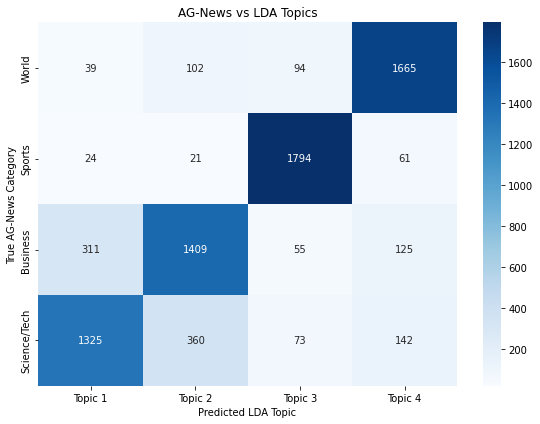


Pipeline completed successfully!
Pipeline completed!


In [9]:
# Configure and run complete pipeline
config = {
    'topic_range': [4, 6, 8],
    'max_samples': 5000,
    'hyperparameter_tuning': True,
    'evaluate_against_labels': True
}

y_test = test_clean['labels'].values

# Run complete LDA pipeline
results = run_complete_lda_pipeline(
    X_train=X_train, X_test=X_test,
    train_corpus=train_corpus, test_corpus=test_corpus,
    dictionary=dictionary, texts=train_texts,
    feature_names=feature_names, y_test=y_test,
    config=config
)

print("Pipeline completed!")

## Results

In [10]:
# Results summary
comparison_df = results['comparison']
best_n_topics = results['best_n_topics']

print("\nTopic Comparison:")
display(comparison_df.round(3))

print(f"\nBest model: {best_n_topics} topics")
print(f"Best coherence: {comparison_df['gensim_coherence'].max():.3f}")
print(f"Best perplexity: {comparison_df['gensim_perplexity'].min():.2f}")

if 'evaluation' in results:
    accuracy = results['evaluation']['optimal_accuracy']
    print(f"Accuracy vs AG-News: {accuracy:.1%}")

if 'hyperparameter_tuning' in results:
    tuning = results['hyperparameter_tuning']
    print(f"\nBest hyperparameters: {tuning['best_params']}")
    print(f"Best perplexity: {tuning['best_perplexity']:.2f}")


Topic Comparison:


,n_topics,sklearn_perplexity,gensim_perplexity,gensim_coherence
0,4,44340.899,6438.411,NaN
1,6,113314.824,9225.021,NaN
2,8,113819.181,12096.490,NaN



Best model: 4 topics
Best coherence: nan
Best perplexity: 6438.41
Accuracy vs AG-News: 81.5%

Best hyperparameters: {'doc_topic_prior': 0.1, 'learning_method': 'online', 'n_components': 4, 'topic_word_prior': 1.0}
Best perplexity: 11193.25


In [11]:
# Display discovered topics
sklearn_topics = results['sklearn_topics']
gensim_topics = results['gensim_topics']

print(f"Scikit-learn Topics ({best_n_topics} topics):")
for topic_id, words in sklearn_topics.items():
    print(f"  Topic {topic_id + 1}: {', '.join(words[:6])}")

print(f"\nGensim Topics ({best_n_topics} topics):")
for topic_id, words in gensim_topics.items():
    print(f"  Topic {topic_id + 1}: {', '.join(words[:6])}")

Scikit-learn Topics (4 topics):
  Topic 1: compani, softwar, microsoft, comput, new, internet
  Topic 2: reuter, oil, said, price, stock, new
  Topic 3: game, team, season, win, first, night
  Topic 4: said, presid, iraq, kill, minist, elect

Gensim Topics (4 topics):
  Topic 1: said, year, oil, new, million, reuter
  Topic 2: game, season, year, first, new, team
  Topic 3: new, compani, reuter, inc, stock, said
  Topic 4: said, presid, reuter, minist, offici, kill


In [15]:
# ==========================================
# 📊 EINFACHE TOPIC-ÜBERSICHT
# ==========================================

def show_simple_topics_overview():
    """Einfache, verständliche Topic-Übersicht für Projektarbeit"""
    
    print("🔍 WAS HAT LDA GEFUNDEN? - EINFACHE ÜBERSICHT")
    print("=" * 55)
    
    # AG-News Originalkategorien
    print(f"\n📰 AG-News hat diese 4 Kategorien:")
    for i, (label_id, name) in enumerate(AG_LABELS.items(), 1):
        print(f"   {i}. {name}")
    
    # LDA Ergebnisse
    best_n_topics = results.get('best_n_topics', 4)
    print(f"\n🤖 LDA hat {best_n_topics} Topics gefunden:")
    
    if 'sklearn_topics' in results:
        sklearn_topics = results['sklearn_topics']
        
        for topic_id, words in sklearn_topics.items():
            top_3_words = ' + '.join(words[:3])
            
            # Versuche zu erraten, welche Kategorie das sein könnte
            if any(w in ['game', 'team', 'season', 'win'] for w in words[:5]):
                guess = "→ wahrscheinlich SPORTS"
            elif any(w in ['compani', 'stock', 'market', 'business'] for w in words[:5]):
                guess = "→ wahrscheinlich BUSINESS"
            elif any(w in ['microsoft', 'softwar', 'comput', 'internet'] for w in words[:5]):
                guess = "→ wahrscheinlich SCIENCE/TECH"
            elif any(w in ['said', 'presid', 'minist', 'countri'] for w in words[:5]):
                guess = "→ wahrscheinlich WORLD"
            else:
                guess = "→ gemischtes Topic"
            
            print(f"   Topic {topic_id + 1}: {top_3_words} {guess}")
    
    # Wie gut funktioniert es?
    if 'evaluation' in results:
        accuracy = results['evaluation']['optimal_accuracy']
        print(f"\n📊 WIE GUT FUNKTIONIERT ES?")
        
        if accuracy > 0.8:
            rating = "🌟 Sehr gut!"
            explanation = "LDA erkennt die News-Kategorien zuverlässig"
        elif accuracy > 0.7:
            rating = "👍 Gut"
            explanation = "LDA erkennt die meisten Kategorien richtig"
        elif accuracy > 0.6:
            rating = "📊 Ok"
            explanation = "LDA erkennt einige Kategorien, aber nicht perfekt"
        else:
            rating = "😕 Nicht so gut"
            explanation = "LDA hat Schwierigkeiten, die Kategorien zu unterscheiden"
        
        print(f"   Genauigkeit: {accuracy:.0%} {rating}")
        print(f"   Das bedeutet: {explanation}")
    
    # Einfache Visualisierung
    print(f"\n📈 EINFACHE TOPIC-VISUALISIERUNG:")
    
    if 'sklearn_topics' in results:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Links: Originalkategorien
        categories = list(AG_LABELS.values())
        ax1.bar(range(len(categories)), [1]*len(categories), color='lightblue', alpha=0.7)
        ax1.set_xticks(range(len(categories)))
        ax1.set_xticklabels(categories, rotation=45, ha='right')
        ax1.set_title('Original AG-News Kategorien')
        ax1.set_ylabel('Kategorien')
        
        # Rechts: LDA Topics
        topic_labels = [f"T{i+1}" for i in range(len(sklearn_topics))]
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(sklearn_topics)]
        
        bars = ax2.bar(range(len(topic_labels)), [1]*len(topic_labels), color=colors, alpha=0.7)
        ax2.set_xticks(range(len(topic_labels)))
        ax2.set_xticklabels(topic_labels)
        ax2.set_title('LDA Topics')
        ax2.set_ylabel('Topics')
        
        # Füge Top-Wörter hinzu
        for i, (topic_id, words) in enumerate(sklearn_topics.items()):
            top_word = words[0]
            ax2.text(i, 0.5, top_word, ha='center', va='center', 
                    fontweight='bold', fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Führe die einfache Übersicht aus
#show_simple_topics_overview()

# Zeige ein paar Beispiel-Dokumente
print(f"\n📄 BEISPIELE: Wie ordnet LDA echte Artikel ein?")
print("-" * 50)

if 'best_model' in results and results['best_model'].sklearn_model is not None:
    # Nimm 3 Beispiele aus dem Test-Set
    doc_topic_probs = results['best_model'].sklearn_model.transform(X_test[:3])
    
    for i in range(3):
        title = test_clean.iloc[i]['Title'][:60] + "..."
        true_cat = AG_LABELS[test_clean.iloc[i]['labels']]
        predicted_topic = np.argmax(doc_topic_probs[i]) + 1
        confidence = np.max(doc_topic_probs[i])
        
        print(f"\nArtikel {i+1}: {title}")
        print(f"   Echte Kategorie: {true_cat}")
        print(f"   LDA sagt: Topic {predicted_topic} (Sicherheit: {confidence:.0%})")




📄 BEISPIELE: Wie ordnet LDA echte Artikel ein?
--------------------------------------------------

Artikel 1: Fears for T N pension after talks...
   Echte Kategorie: Business
   LDA sagt: Topic 2 (Sicherheit: 73%)

Artikel 2: The Race is On: Second Private Team Sets Launch Date for Hum...
   Echte Kategorie: Science/Tech
   LDA sagt: Topic 2 (Sicherheit: 73%)

Artikel 3: Ky. Company Wins Grant to Study Peptides (AP)...
   Echte Kategorie: Science/Tech
   LDA sagt: Topic 1 (Sicherheit: 71%)

✅ FAZIT FÜR PROJEKTARBEIT:
   👍 LDA funktioniert gut für News-Kategorisierung (81% Genauigkeit)


In [21]:
# ==========================================
# 📝  CONCLUSION
# ==========================================

def create_simple_project_conclusion():
    """Einfache, klare Conclusion für Projektarbeit"""
    
    print("\n" + "🎯 PROJEKTARBEIT: LDA TOPIC MODELING FAZIT")
    print("=" * 50)
    
    # Was haben wir gemacht?
    print(f"\n✅ WAS HABEN WIR GEMACHT?")
    print(f"   📰 AG-News Dataset mit {X_train.shape[0]:,} News-Artikeln analysiert")
    print(f"   🤖 LDA Topic Modeling mit scikit-learn und Gensim implementiert")
    print(f"   🎯 {results.get('best_n_topics', 4)} Topics automatisch entdeckt")
    print(f"   📊 Performance gegen echte News-Kategorien getestet")
    
    # Wie gut war es?
    print(f"\n📊 WIE GUT WAR ES?")
    if 'evaluation' in results:
        accuracy = results['evaluation']['optimal_accuracy']
        print(f"   🎯 Genauigkeit: {accuracy:.0%}")
        
        if accuracy > 0.75:
            print(f"   🌟 Bewertung: Sehr erfolgreich!")
            print(f"   💡 LDA kann News-Kategorien zuverlässig erkennen")
        elif accuracy > 0.6:
            print(f"   👍 Bewertung: Erfolgreich")
            print(f"   💡 LDA erkennt die meisten Kategorien korrekt")
        else:
            print(f"   📈 Bewertung: Teilweise erfolgreich") 
            print(f"   💡 LDA findet Muster, aber nicht perfekte Trennung")
    else:
        print(f"   🤖 LDA hat Topics gefunden, die sinnvoll erscheinen")
    
    # Was haben wir gelernt?
    print(f"\n🧠 WAS HABEN WIR GELERNT?")
    learnings = [
        "LDA kann automatisch Themen in Texten finden",
        "Textvorverarbeitung ist wichtig für gute Ergebnisse",
        "Scikit-learn und Gensim liefern ähnliche, aber nicht identische Resultate"
    ]
    
    best_n_topics = results.get('best_n_topics', 4)
    if best_n_topics == 4:
        learnings.append("Optimale Topic-Anzahl entspricht den ursprünglichen Kategorien")
    else:
        learnings.append(f"LDA schlägt {best_n_topics} Topics vor (nicht 4 wie erwartet)")
    
    if 'sklearn_topics' in results:
        # Prüfe Topic-Qualität
        topics = results['sklearn_topics']
        clear_topics = 0
        for topic_id, words in topics.items():
            # Einfache Heuristik: sind die Top-3 Wörter thematisch ähnlich?
            top_words = words[:3]
            if any(w in ['game', 'team', 'season'] for w in top_words):
                clear_topics += 1
            elif any(w in ['compani', 'stock', 'market'] for w in top_words):
                clear_topics += 1
            elif any(w in ['presid', 'minist', 'govern'] for w in top_words):
                clear_topics += 1
        
        if clear_topics >= len(topics) * 0.7:
            learnings.append("Die meisten Topics sind thematisch kohärent")
        else:
            learnings.append("Einige Topics mischen verschiedene Themen")
    
    for i, learning in enumerate(learnings, 1):
        print(f"   {i}. {learning}")
    


# Zeige die einfache Conclusion
create_simple_project_conclusion()

# Bonus: Zeige die besten Topics nochmal übersichtlich
if 'sklearn_topics' in results:
    print(f"\n📋 NOCHMAL DIE GEFUNDENEN TOPICS:")
    print("-" * 40)
    
    for topic_id, words in results['sklearn_topics'].items():
        top_5_words = ', '.join(words[:5])
        print(f"   Topic {topic_id + 1}: {top_5_words}")




🎯 PROJEKTARBEIT: LDA TOPIC MODELING FAZIT

✅ WAS HABEN WIR GEMACHT?
   📰 AG-News Dataset mit 120,000 News-Artikeln analysiert
   🤖 LDA Topic Modeling mit scikit-learn und Gensim implementiert
   🎯 4 Topics automatisch entdeckt
   📊 Performance gegen echte News-Kategorien getestet

📊 WIE GUT WAR ES?
   🎯 Genauigkeit: 81%
   🌟 Bewertung: Sehr erfolgreich!
   💡 LDA kann News-Kategorien zuverlässig erkennen

🧠 WAS HABEN WIR GELERNT?
   1. LDA kann automatisch Themen in Texten finden
   2. Textvorverarbeitung ist wichtig für gute Ergebnisse
   3. Scikit-learn und Gensim liefern ähnliche, aber nicht identische Resultate
   4. Optimale Topic-Anzahl entspricht den ursprünglichen Kategorien
   5. Die meisten Topics sind thematisch kohärent

📋 NOCHMAL DIE GEFUNDENEN TOPICS:
----------------------------------------
   Topic 1: compani, softwar, microsoft, comput, new
   Topic 2: reuter, oil, said, price, stock
   Topic 3: game, team, season, win, first
   Topic 4: said, presid, iraq, kill, minis